In [2]:
!pip install trimesh

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 711.7/711.7 kB 20.0 MB/s eta 0:00:00


In [3]:
import os
import glob
import trimesh
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [4]:
classes=['bathtub','bed','chair','desk','dresser','monitor','night_stand','sofa','table','toilet']

path="http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip"
data_dir=tf.keras.utils.get_file('modelnet.zip',path,extract=True)
data_dir=os.path.join(data_dir,'ModelNet10')

473402300/473402300 ━━━━━━━━━━━━━━━━━━━━ 12s 0us/step


In [5]:
def parse_dataset(num_points=2048):
    train_points,train_labels=[],[]
    test_points,test_labels=[],[]

    for i in range(len(classes)):
        folder=os.path.join(data_dir,classes[i])
        print('데이터 읽기: 부류 {}'.format(os.path.basename(folder)))
        train_files=glob.glob(os.path.join(folder,'train/*'))
        test_files=glob.glob(os.path.join(folder,'test/*'))

        for f in train_files:
            train_points.append(trimesh.load(f).sample(num_points))
            train_labels.append(i)
        for f in test_files:
            test_points.append(trimesh.load(f).sample(num_points))
            test_labels.append(i)
    return(np.array(train_points),np.array(test_points),np.array(train_labels),np.array(test_labels))

In [6]:
NUM_POINTS=2048		# 샘플 영상의 점의 개수
NUM_CLASSES=10		# 부류 개수
batch_siz=32

x_train,x_test,y_train,y_test=parse_dataset(NUM_POINTS)

데이터 읽기: 부류 bathtub
데이터 읽기: 부류 bed
데이터 읽기: 부류 chair
데이터 읽기: 부류 desk
데이터 읽기: 부류 dresser
데이터 읽기: 부류 monitor
데이터 읽기: 부류 night_stand
데이터 읽기: 부류 sofa
데이터 읽기: 부류 table
데이터 읽기: 부류 toilet


In [7]:
def conv_bn(x,filters):	# 컨볼루션층과 배치 정규화
    x=layers.Conv1D(filters,kernel_size=1,padding='valid')(x)
    x=layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation('relu')(x)

def dense_bn(x,filters):	# 완전연결층과 배치 정규화
    x=layers.Dense(filters)(x)
    x=layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation('relu')(x)

In [8]:
class OrthogonalRegularizer(keras.regularizers.Regularizer):
    def __init__(self,num_features,l2reg=0.001):
        self.num_features=num_features
        self.l2reg=l2reg
        self.eye=tf.eye(num_features)

    def __call__(self,x):
        x=tf.reshape(x,(-1,self.num_features,self.num_features))
        xxt=tf.tensordot(x,x,axes=(2,2))
        xxt=tf.reshape(xxt,(-1,self.num_features,self.num_features))
        return tf.reduce_sum(self.l2reg*tf.square(xxt-self.eye))

In [9]:
def tnet(inputs,num_features):			# T-Net
    bias=keras.initializers.Constant(np.eye(num_features).flatten())
    reg=OrthogonalRegularizer(num_features)

    x=conv_bn(inputs,32)
    x=conv_bn(x,64)
    x=conv_bn(x,512)
    x=layers.GlobalMaxPooling1D()(x)
    x=dense_bn(x,256)
    x=dense_bn(x,128)
    x=layers.Dense(num_features*num_features,kernel_initializer='zeros',bias_initializer=bias,activity_regularizer=reg)(x)

    feat_T=layers.Reshape((num_features, num_features))(x)
    return layers.Dot(axes=(2,1))([inputs,feat_T]) # 특징 맵에 어파인 변환(3*3행렬) 적용

In [10]:
inputs=keras.Input(shape=(NUM_POINTS,3))	# PointNet의 입력
x=tnet(inputs,3)		# PointNet 구축 (특징 맵은 논문의 반절로 설정)
x=conv_bn(x,32)
x=conv_bn(x,32)
x=tnet(x,32)
x=conv_bn(x,32)
x=conv_bn(x,64)
x=conv_bn(x,512)
x=layers.GlobalMaxPooling1D()(x)
x=dense_bn(x,256)
x=layers.Dropout(0.3)(x)
x=dense_bn(x,128)
x=layers.Dropout(0.3)(x)
outputs=layers.Dense(NUM_CLASSES,activation='softmax')(x) # PointNet 출력

model=keras.Model(inputs=inputs,outputs=outputs,name='pointnet')

model.compile(loss='sparse_categorical_crossentropy',optimizer=keras.optimizers.Adam(learning_rate=0.001),metrics=["sparse_categorical_accuracy"])
model.fit(x_train,y_train,epochs=20,validation_data=(x_test,y_test))

chosen=np.random.randint(0,len(x_test),8)
points=x_test[chosen]		# 앞에 배치된 8개 샘플을 예측해봄
labels=y_test[chosen]

preds=model.predict(points)
preds=tf.math.argmax(preds,-1)

Epoch 1/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 39s 134ms/step - loss: 43.8896 - sparse_categorical_accuracy: 0.2440 - val_loss: 14250684005893118361600.0000 - val_sparse_categorical_accuracy: 0.1850
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 19s 41ms/step - loss: 36.5045 - sparse_categorical_accuracy: 0.2993 - val_loss: 146100560330752.0000 - val_sparse_categorical_accuracy: 0.2423
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - loss: 35.9182 - sparse_categorical_accuracy: 0.3583 - val_loss: 35.8428 - val_sparse_categorical_accuracy: 0.1927
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - loss: 35.9269 - sparse_categorical_accuracy: 0.3884 - val_loss: 1207647898435584.0000 - val_sparse_categorical_accuracy: 0.2819
Epoch 5/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - loss: 35.8517 - sparse_categorical_accuracy: 0.3862 - val_loss: 8902486878322688.0000 - val_sparse_categorical_accuracy: 0.2676
Epoch 6/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - loss: 36.1037 - sparse_categorical_

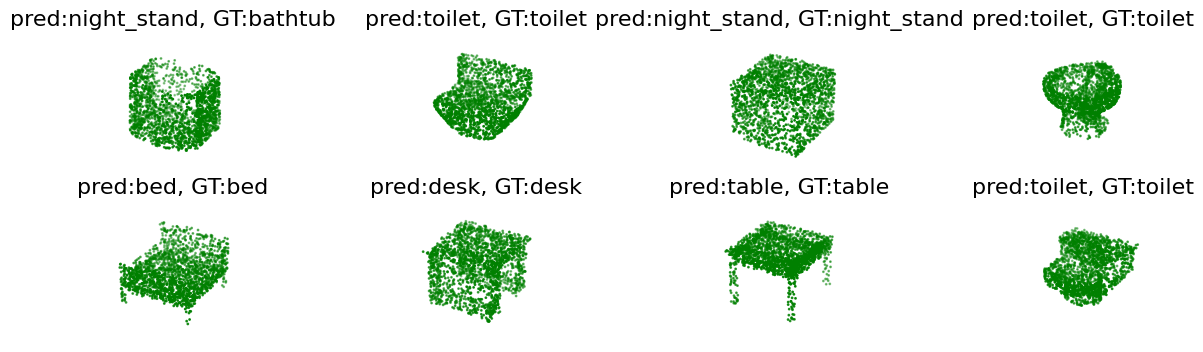

In [11]:
fig=plt.figure(figsize=(15,4))	# 예측 결과를 시각화
for i in range(8):
    ax=fig.add_subplot(2,4,i+1,projection='3d')
    ax.scatter(points[i,:,0],points[i,:,1],points[i,:,2],s=1,c='g')
    ax.set_title('pred:{:}, GT:{:}'.format(classes[preds[i].numpy()],classes[labels[i]]),fontsize=16)
    ax.set_axis_off()